In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
import xgboost as xgb

class RBM:
    def __init__(self, visible_dim, hidden_dim, learning_rate=0.01):
        self.visible_dim = visible_dim
        self.hidden_dim = hidden_dim
        self.learning_rate = learning_rate

        # Initialize weights and biases
        self.weights = tf.Variable(tf.random.normal([visible_dim, hidden_dim], mean=0.0, stddev=0.01), dtype=tf.float32)
        self.visible_bias = tf.Variable(tf.zeros([visible_dim]), dtype=tf.float32)
        self.hidden_bias = tf.Variable(tf.zeros([hidden_dim]), dtype=tf.float32)

    # Gibbs sampling steps
    def sample_hidden(self, visible):
        hidden_probs = tf.nn.sigmoid(tf.matmul(visible, self.weights) + self.hidden_bias)
        hidden_states = tf.nn.relu(tf.sign(hidden_probs - tf.random.uniform(tf.shape(hidden_probs))))
        return hidden_states, hidden_probs

    def sample_visible(self, hidden):
        visible_probs = tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(self.weights)) + self.visible_bias)
        visible_states = tf.nn.relu(tf.sign(visible_probs - tf.random.uniform(tf.shape(visible_probs))))
        return visible_states, visible_probs

    # Contrastive divergence
    def contrastive_divergence(self, input_data, k=1):
        visible_states = input_data

        # Positive phase
        hidden_states_pos, hidden_probs_pos = self.sample_hidden(visible_states)

        # Gibbs sampling for k steps
        hidden_states = hidden_states_pos
        for _ in range(k):
            visible_states, _ = self.sample_visible(hidden_states)
            hidden_states, hidden_probs_neg = self.sample_hidden(visible_states)

        # Update weights and biases
        positive_grad = tf.matmul(tf.transpose(input_data), hidden_probs_pos)
        negative_grad = tf.matmul(tf.transpose(visible_states), hidden_probs_neg)

        self.weights.assign_add(self.learning_rate * (positive_grad - negative_grad) / tf.cast(tf.shape(input_data)[0], tf.float32))
        self.visible_bias.assign_add(self.learning_rate * tf.reduce_mean(input_data - visible_states, axis=0))
        self.hidden_bias.assign_add(self.learning_rate * tf.reduce_mean(hidden_probs_pos - hidden_probs_neg, axis=0))

    # Training function
    def train(self, data, epochs=10, batch_size=64, k=1):
        dataset = tf.data.Dataset.from_tensor_slices(data).batch(batch_size)
        for epoch in range(epochs):
            for batch in dataset:
                self.contrastive_divergence(batch, k)
            print(f'Epoch {epoch+1} completed.')

    # Transform visible data to hidden representation
    def transform(self, data):
        _, hidden_probs = self.sample_hidden(data)
        return hidden_probs.numpy()

In [3]:
df = pd.read_csv('../data/files/audio_classification_5sec.csv')

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler

def clean_labels(s):
    return s.split('.')[0]

def map_shifted(s):
    if s.endswith('_1.wav') or s.endswith('_2.wav'):
        return 1
    return 0

labelMap = {
    "blues": 0,
    "classical": 1,
    "country": 2,
    "disco": 3,
    "hiphop": 4,
    "jazz": 5,
    "metal": 6,
    "pop": 7,
    "reggae": 8,
    "rock": 9
}

X = df.drop([df.columns[0]], axis=1)
y = list(map(lambda x: labelMap[x], df[df.columns[0]]))

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1122, stratify=y, test_size=0.3)

indices = np.where(X_test[X_test.columns[-1]] == 1)

X_test = X_test.drop([X_test.columns[-1]], axis=1)
X_train = X_train.drop([X_train.columns[-1]], axis=1)

y_test = pd.DataFrame(y_test)
y_test = np.array(y_test.drop(y_test.index[indices]))
X_test = X_test.drop(X_test.index[indices])

scaler = MaxAbsScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

[0]	validation_0-mlogloss:1.97318	validation_1-mlogloss:1.98919
[1]	validation_0-mlogloss:1.79203	validation_1-mlogloss:1.80793
[2]	validation_0-mlogloss:1.65265	validation_1-mlogloss:1.66518
[3]	validation_0-mlogloss:1.54306	validation_1-mlogloss:1.55978
[4]	validation_0-mlogloss:1.45364	validation_1-mlogloss:1.46779
[5]	validation_0-mlogloss:1.37566	validation_1-mlogloss:1.38997
[6]	validation_0-mlogloss:1.31199	validation_1-mlogloss:1.32660
[7]	validation_0-mlogloss:1.24992	validation_1-mlogloss:1.26743
[8]	validation_0-mlogloss:1.20001	validation_1-mlogloss:1.21557
[9]	validation_0-mlogloss:1.15281	validation_1-mlogloss:1.16937
[10]	validation_0-mlogloss:1.11118	validation_1-mlogloss:1.13030
[11]	validation_0-mlogloss:1.07394	validation_1-mlogloss:1.09416
[12]	validation_0-mlogloss:1.03959	validation_1-mlogloss:1.06074
[13]	validation_0-mlogloss:1.00591	validation_1-mlogloss:1.03300
[14]	validation_0-mlogloss:0.97662	validation_1-mlogloss:1.00720
[15]	validation_0-mlogloss:0.94763	

C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:729: UserWarning: [14:31:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


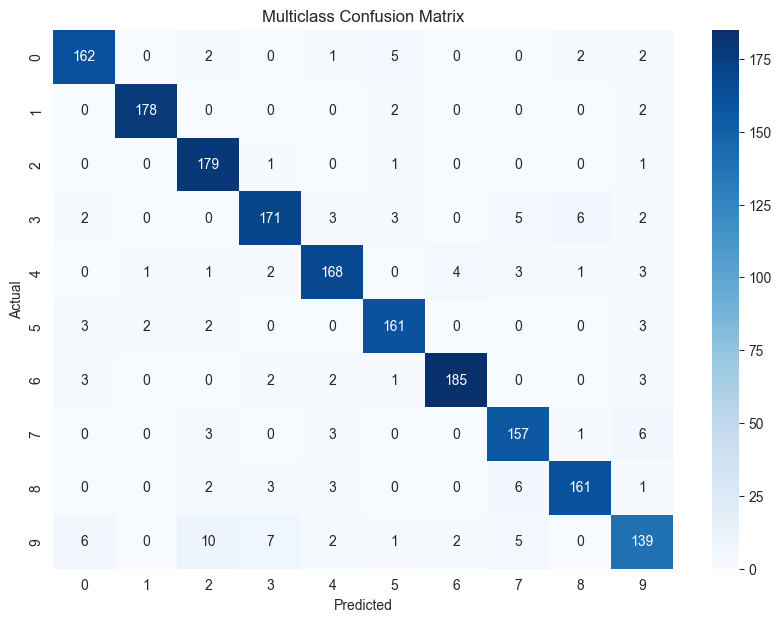

In [5]:
labels = labelMap.values()

clf = xgb.XGBClassifier(
    objective='multi:softmax',
    n_estimators=3000,
    learning_rate=0.25,
    max_depth=3,
    booster="gbtree",
    random_state=1122,
    eval_metric='mlogloss',
    early_stopping_rounds=15,
    device='cuda',
    n_jobs=-1
)

eval_set = [(X_train_scaled, y_train), (X_test_scaled, y_test)]
clf.fit(X_train_scaled, y_train, eval_set=eval_set)

predictions = clf.predict(X_test_scaled)
print('Accuracy:', accuracy_score(y_test, predictions))

import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Multiclass Confusion Matrix')
    plt.show()

# Call function:
plot_confusion_matrix(y_test, predictions, labels)

In [6]:
print(classification_report(y_true=y_test, y_pred=predictions))

              precision    recall  f1-score   support

           0       0.92      0.93      0.93       174
           1       0.98      0.98      0.98       182
           2       0.90      0.98      0.94       182
           3       0.92      0.89      0.90       192
           4       0.92      0.92      0.92       183
           5       0.93      0.94      0.93       171
           6       0.97      0.94      0.96       196
           7       0.89      0.92      0.91       170
           8       0.94      0.91      0.93       176
           9       0.86      0.81      0.83       172

    accuracy                           0.92      1798
   macro avg       0.92      0.92      0.92      1798
weighted avg       0.92      0.92      0.92      1798



Accuracy: 0.803670745272525


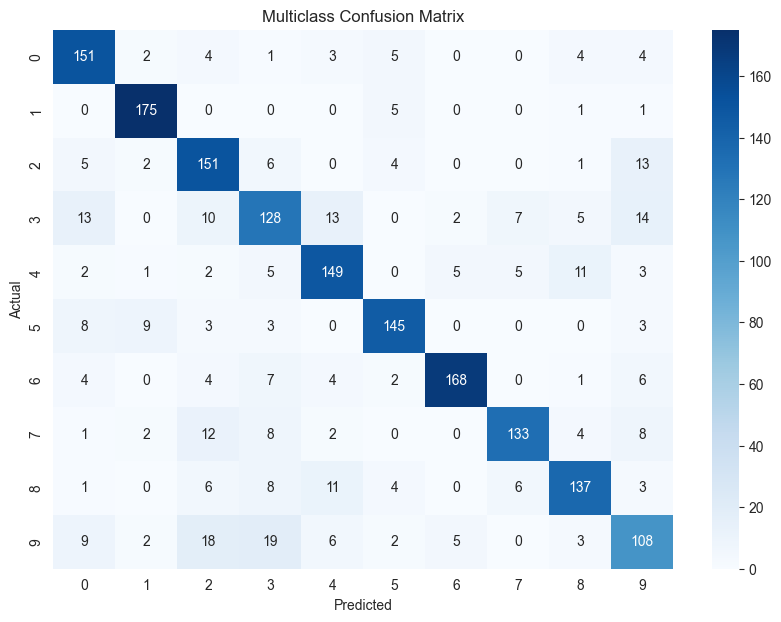

In [7]:
labels = labelMap.values()

clf = SVC(kernel='rbf', random_state=1122)

eval_set = [(X_train_scaled, y_train), (X_test_scaled, y_test)]
clf.fit(X_train_scaled, y_train)

predictions = clf.predict(X_test_scaled)
print('Accuracy:', accuracy_score(y_test, predictions))

# Call function:
plot_confusion_matrix(y_test, predictions, labels)

In [ ]:
print(classification_report(y_true=y_test, y_pred=predictions))

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [500, 1000, 2000, 3000],
    'max_depth': [1, 2, 3],
    'learning_rate': [0.02, 0.025, 0.0275],
    'subsample': [0.7, 0.75, 0.8]
}

grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

# Fit the grid search on the training data
grid_search.fit(X_train_scaled, y_train, eval_set=eval_set, verbose=1)

print("Best Parameters:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)

# 6. Evaluate on the test set using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy with best hyperparameters:", test_accuracy)

In [ ]:
print(classification_report(y_true=y_test, y_pred=y_pred))
plot_confusion_matrix(y_test, predictions, labels)

In [ ]:
clf = KNeighborsClassifier(n_neighbors=2)
clf.fit(X_train_scaled, y_train)

predictions = clf.predict(X_test_scaled)
print('Accuracy:', accuracy_score(y_test, predictions))

# Call function:
plot_confusion_matrix(y_test, predictions, labels)

In [225]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras import utils
from tensorflow import keras

X_train_scaled = X_train_scaled.astype(np.float32)

input_shape = X_train_scaled.shape[1:]  # (92,)
num_classes = len(labels)

model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    Dropout(0.2),
    MaxPooling1D(2),
    Dense(100, activation='relu'),
    Dense(num_classes, activation="softmax"),
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_81 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_185 (Dense)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_186 (Dense)               │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [226]:
y_train_categorical = utils.to_categorical(y_train, num_classes=10)
y_test_categorical = utils.to_categorical(y_test, num_classes=10)

history = model.fit(
    X_train_scaled, np.array(y_train_categorical),
    epochs=200, batch_size=64, validation_split=0.2, verbose=1
)

test_loss, test_acc = model.evaluate(X_test_scaled, y_test_categorical, verbose=2)
print(f"Test Accuracy: {test_acc:.2%}")

y_pred = model.predict(X_test).argmax(axis=1)

Epoch 1/200


ValueError: Input 0 of layer "conv1d" is incompatible with the layer: expected min_ndim=3, found ndim=2. Full shape received: (None, 122)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       174
           1       1.00      0.01      0.01       182
           2       0.00      0.00      0.00       182
           3       0.11      0.99      0.19       192
           4       0.00      0.00      0.00       183
           5       0.00      0.00      0.00       171
           6       0.00      0.00      0.00       196
           7       0.00      0.00      0.00       170
           8       0.00      0.00      0.00       176
           9       0.11      0.01      0.02       172

    accuracy                           0.11      1798
   macro avg       0.12      0.10      0.02      1798
weighted avg       0.12      0.11      0.02      1798



C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

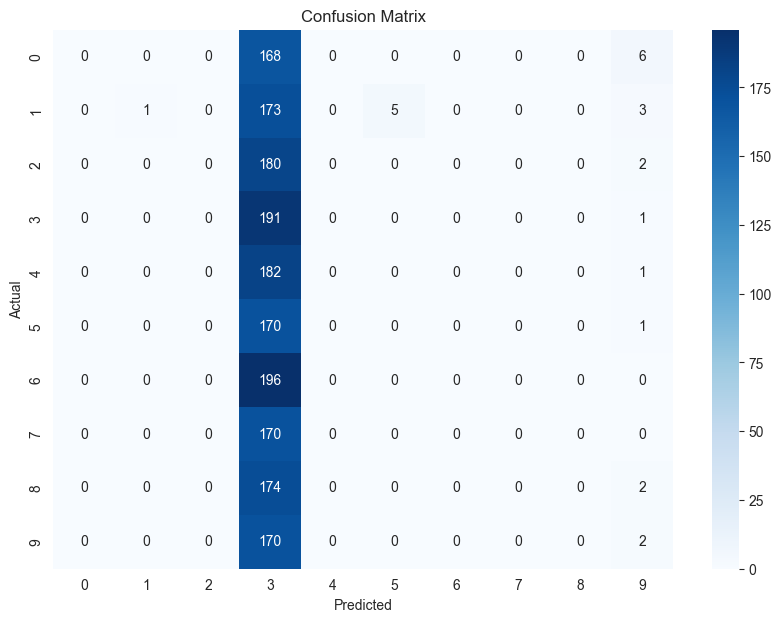

In [221]:
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()